In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

In [54]:
plt.style.use('dark_background')

### Read in Xenium file

In [4]:
xenium_scdata = sc.read_h5ad(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Subset into separate h5ads based on sample id

In [6]:
c3m1 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C3m1']
c3m2 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C3m2']
c3m3 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C3m3']
c24m1 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C24m1']
c24m2 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C24m2']
c24m3 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'C24m3']
hd24m1 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'HD24m1']
hd24m2 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'HD24m2']
hd24m3 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'HD24m3']
r61 = xenium_scdata[xenium_scdata.obs['Sample ID'] == 'R61']

### Recluster and generate umap: c24m2

In [14]:
sc.pp.pca(c24m2, n_comps = 50)
umap_operator = umap.UMAP(n_components = 2, random_state = 42)
umap_result_xenium = umap_operator.fit_transform(c24m2.obsm['X_pca'])
sc.pp.neighbors(c24m2, use_rep = 'X_umap', n_neighbors=20)
sc.tl.leiden(c24m2, resolution = 0.1) #0.003125

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


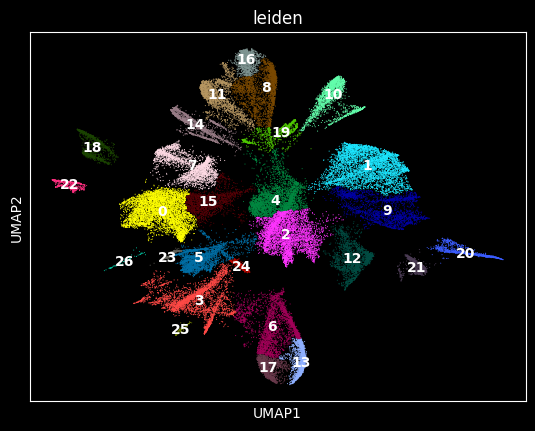

In [15]:
sc.pl.umap(c24m2, color = 'leiden', legend_loc = 'on data')

### Run cell type labeling for c24m2

In [16]:
fl = r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\allen_brain_atlas_trimmed_means.csv"
aba = pd.read_csv(fl)
#list(aba.columns)
aba_column_list = list(aba.columns)
#aba_column_list
aba_column_list_revised = ['feature']
for i in range(1,len(aba_column_list)):
    aba_column_list_revised.append(aba_column_list[i].split('_')[1])
aba.columns = aba_column_list_revised
#aba.to_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\allen_brain_atlas_trimmed_means.csv", index = False)
aba

feature     Pvalb  L6 IT CTX  Ntng1 HPF       Sst  Lamp5 Lhx6  \
0      0610005C13Rik  0.000000   0.000000   0.000000  0.000000    0.000000   
1      0610006L08Rik  0.000000   0.000000   0.000000  0.000000    0.000000   
2      0610007P14Rik  6.149091   6.844643   6.503429  6.368064    6.716667   
3      0610009B22Rik  6.393636   6.366785   6.951667  6.568254    6.811984   
4      0610009E02Rik  0.000000   0.000000   0.000000  0.000000    0.000000   
...              ...       ...        ...        ...       ...         ...   
45763       n-R5s142  0.000000   0.000000   0.000000  0.000000    0.000000   
45764       n-R5s143  0.000000   0.000000   0.000000  0.000000    0.000000   
45765       n-R5s144  0.000000   0.000000   0.000000  0.000000    0.000000   
45766       n-R5s146  0.000000   0.000000   0.000000  0.000000    0.000000   
45767       n-R5s149  0.000000   0.000000   0.000000  0.000000    0.000000   

          Pvalb  CA2-IG-FC      Car3    CA1-do  ...       Vip  L4/5 IT CTX  \
0      0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   
1      0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   
2      6.123093     6.8675  7.097313  6.410685  ...  6.494454     6.175000   
3      6.551165     5.9700  6.389925  6.239452  ...  6.431515     5.994375   
4      0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.085833   
...         ...        ...       ...       ...  ...       ...          ...   
45763  0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   
45764  0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   
45765  0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   
45766  0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   
45767  0.000000     0.0000  0.000000  0.000000  ...  0.000000     0.000000   

       L5/6 IT CTX       CA1  L5 PT CTX     ProS  L4 IT CTX  L6 CT CTX  \
0         0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   
1         0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   
2         6.520834  6.937000   6.227551  6.77750   6.451691   6.607911   
3         6.242500  6.505333   6.221458  6.59125   6.113125   6.669403   
4         0.000000  0.000000   0.000000  0.05200   0.000000   0.077822   
...            ...       ...        ...      ...        ...        ...   
45763     0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   
45764     0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   
45765     0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   
45766     0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   
45767     0.000000  0.000000   0.000000  0.00000   0.000000   0.000000   

          Astro  L6 CT ENT  
0      0.000000   0.000000  
1      0.000000   0.000000  
2      7.525000   6.529638  
3      1.761538   6.052993  
4      0.000000   0.000000  
...         ...        ...  
45763  0.000000   0.000000  
45764  0.000000   0.000000  
45765  0.000000   0.000000  
45766  0.000000   0.000000  
45767  0.000000   0.000000  

[45768 rows x 383 columns]

In [17]:
def generate_cell_type(xenium_scdata_revised_rescaled, aba):
    sc.pp.log1p(xenium_scdata_revised_rescaled.X)
    sc.tl.rank_genes_groups(xenium_scdata_revised_rescaled, groupby = 'leiden', method = 'wilcoxon', use_raw = False)
    gene_expression_df = pd.DataFrame()
    for cluster in xenium_scdata_revised_rescaled.obs['leiden'].cat.categories:
        cluster_gene_name = xenium_scdata_revised_rescaled.uns['rank_genes_groups']['names'][cluster]
        cluster_gene_score = xenium_scdata_revised_rescaled.uns['rank_genes_groups']['scores'][cluster]
        gene_expression_df[cluster] = {key: val for key, val in zip(cluster_gene_name, cluster_gene_score)}
    gene_expression_df.index = gene_expression_df.index.map(str.capitalize)
    gene_expression_df = gene_expression_df.T
    genes_list = gene_expression_df.columns.tolist()
    #comparison_df = ref_df[ref_df['feature'].isin(genes_list)].reset_index().drop(columns = ['index']).set_index('feature')
    comparison_df = aba[aba['feature'].isin(genes_list)].reset_index().drop(columns = ['index']).set_index('feature').T
    comparison_df = comparison_df.groupby(comparison_df.index).mean().T
    gene_expression_df_postprocessed = gene_expression_df.loc[:, gene_expression_df.columns.isin(comparison_df.index)]
    update_list_genes = np.array(gene_expression_df_postprocessed.columns)
    scdata_subset = xenium_scdata_revised_rescaled[:, xenium_scdata_revised_rescaled.var_names.isin(update_list_genes)].copy()
    scdata_subset.X_expand = scdata_subset.X.toarray()
    X_MERFISH_zscored = zscore(scdata_subset.X_expand, axis=0)
    clusters = scdata_subset.obs['leiden']
    uclusters = np.unique(clusters)
    X_MERFISH_zscored_per_cluster = np.array([np.mean(X_MERFISH_zscored[cl==clusters],axis=0) for cl in uclusters])
    #X_seq = np.array(comparison_df.iloc[:,1:]).T
    X_seq = np.array(comparison_df.iloc[:,0:]).T
    X_seq[np.isnan(X_seq)]=0
    X_seq_zscored = zscore(X_seq,axis=0)
    X_seq_zscored[np.isnan(X_seq_zscored)]=0
    Mcor = [[np.corrcoef(clMER,clSEQ)[0,1] for clSEQ in X_seq_zscored] for clMER in X_MERFISH_zscored_per_cluster]
    #names_seq = list(comparison_df.keys())[1:]
    names_seq = list(comparison_df.keys())[0:]

    Mcor_t = np.array(Mcor).T

    plt.style.use('dark_background')
    #plt.figure(figsize=(120,200))
    plt.figure(figsize=(15,25))
    #plt.imshow(xenium_Mcor,cmap='bwr')
    plt.imshow(Mcor_t,cmap='bwr')
    plt.yticks(np.arange(len(names_seq)),names_seq,rotation=35,ha='right');
    #plt.yticks(np.arange(len(uclusters)),[(ucl,dic_rename[ucl])for ucl in uclusters]);
    plt.xticks(np.arange(len(uclusters)),uclusters)
    plt.xlabel('Cell Clusters from our MERFISH in mouse cortex', size=30)
    plt.ylabel('Cell Clusters from sn-RNASeq in mouse cortex \n(Allan Brian Atlas)', size=30);
    plt.tick_params(axis='x', top=True)
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_g

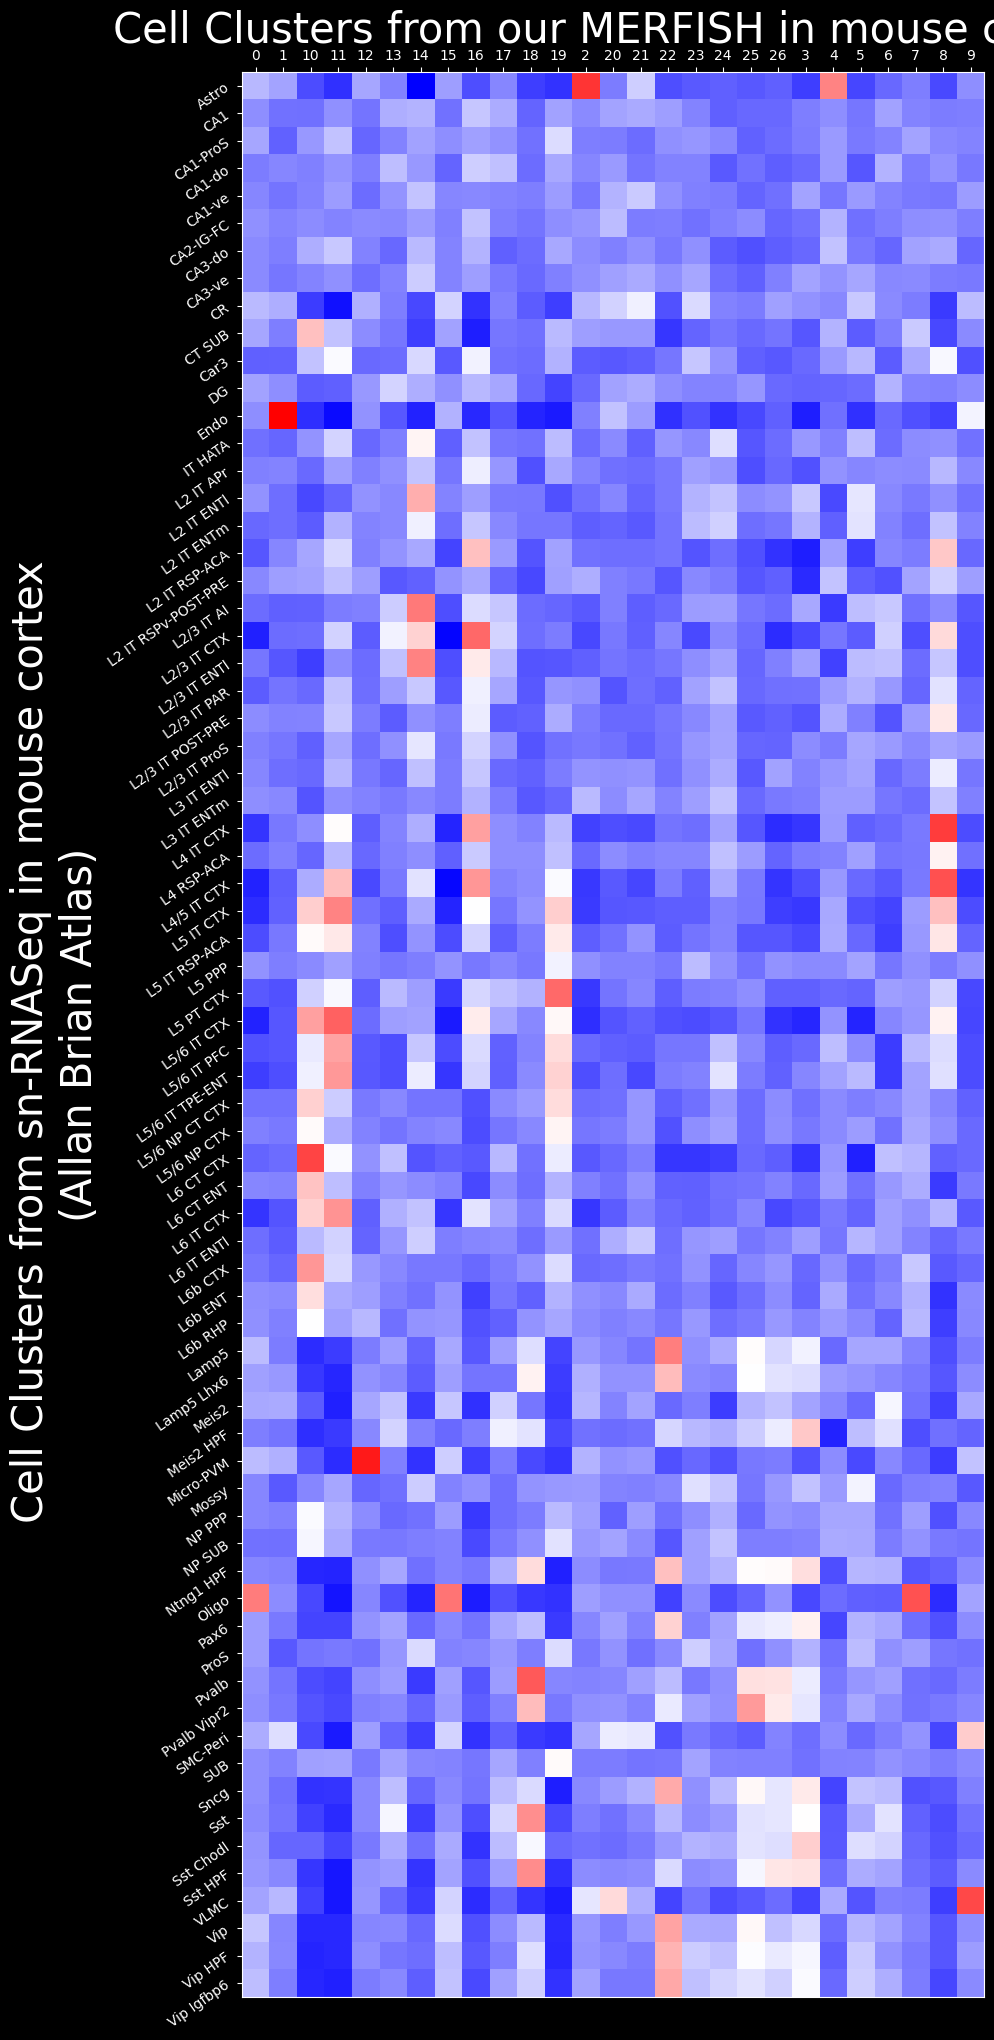

In [18]:
generate_cell_type(c24m2, aba)

In [20]:
c24m2_cell_type_map = {
    '0': 'Oligo',
    '1': 'Endo',
    '2': 'Astro',
    '3': 'Meis2 HPF / Sst Chodl',
    '4': 'Astro',
    '5': 'CLUSTER 5',
    '6': 'CLUSTER 6',
    '7': 'Oligo',
    '8': 'L4 IT CTX / L4/5 IT CTX',
    '9': 'VLMC',
    '10': 'L6 CT CTX',
    '11': 'L5/6 IT CTX',
    '12': 'Micro-PVM',
    '13': 'CLUSTER 13',
    '14': 'L2/3 IT AI/ENTI',
    '15': 'Oligo',
    '16': 'L2/3 IT CTX',
    '17': 'CLUSTER 17',
    '18': 'Pvalb',
    '19': 'L5 PT CTX',
    '20': 'Vip',
    '21': 'CLUSTER 21',
    '22': 'Lamp5',
    '23': 'CLUSTER 23',
    '24': 'CLUSTER 24',
    '25': 'Pvalb Vipr2',
    '26': 'Pvalb / VLMC'
}

In [21]:
# Convert category keys in the dictionary to strings
c24m2_cluster_name_mapping = {str(k): v for k, v in c24m2_cell_type_map.items()}

# Map cluster IDs to cluster names using the updated dictionary
c24m2.obs['cluster_names'] = c24m2.obs['leiden'].astype(str).map(c24m2_cluster_name_mapping)

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


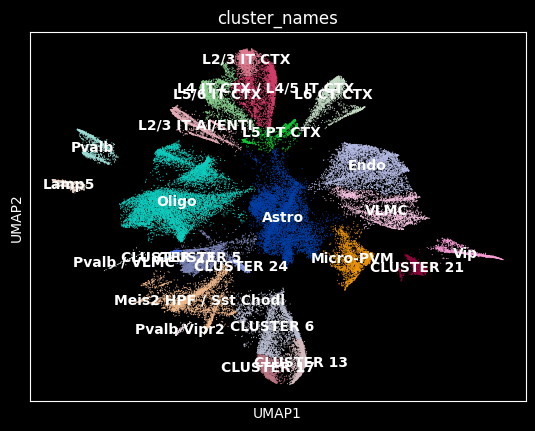

In [22]:
sc.pl.umap(c24m2, color = 'cluster_names', legend_loc = 'on data')

# Unlabeled clusters

### Find top expressed genes

In [23]:
raw_counts = c24m2.X
raw_counts_dense = raw_counts.toarray()
#raw_counts_dense
c24m2_raw_count_df_column_name = list(c24m2.var.index)
#xenium_raw_count_df_column_name
leiden_clusters = c24m2.obs['leiden']
leiden_clusters_list = list(leiden_clusters.index)
#leiden_clusters_list
c24m2_raw_count_df = pd.DataFrame(raw_counts_dense)
c24m2_raw_count_df.columns = c24m2_raw_count_df_column_name
c24m2_raw_count_df = c24m2_raw_count_df.T
c24m2_raw_count_df.columns = leiden_clusters_list
c24m2_raw_count_df = c24m2_raw_count_df.T
c24m2_raw_count_df = c24m2_raw_count_df.assign(leiden_cluster = leiden_clusters)
c24m2_raw_count_df = c24m2_raw_count_df.groupby('leiden_cluster').sum()
#xenium_raw_count_df.to_csv('xenium_raw_count_leiden.csv',index=True, mode='w')
#c24m2_raw_count_df

In [25]:
unlabeled_array = np.array(['5','6','13','17','21','23','24'])
color_palette = sns.color_palette("Set2")
raw_gene_array = np.empty((0,20))
for cluster in unlabeled_array:
    raw_gene_array_by_cluster = []
    for gene in c24m2.uns['rank_genes_groups']['names'][cluster][:20]:
        raw_gene_array_by_cluster = np.append(raw_gene_array_by_cluster, c24m2_raw_count_df.at[cluster, gene])
    raw_gene_array = np.vstack((raw_gene_array, raw_gene_array_by_cluster))

C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


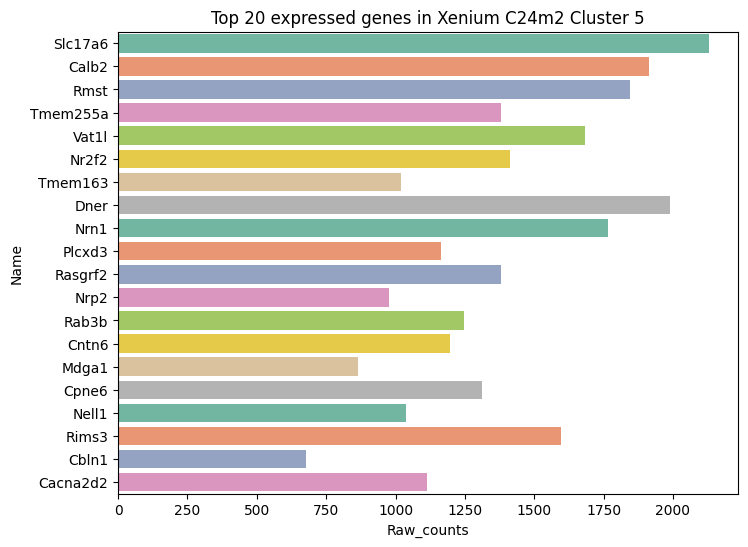

C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


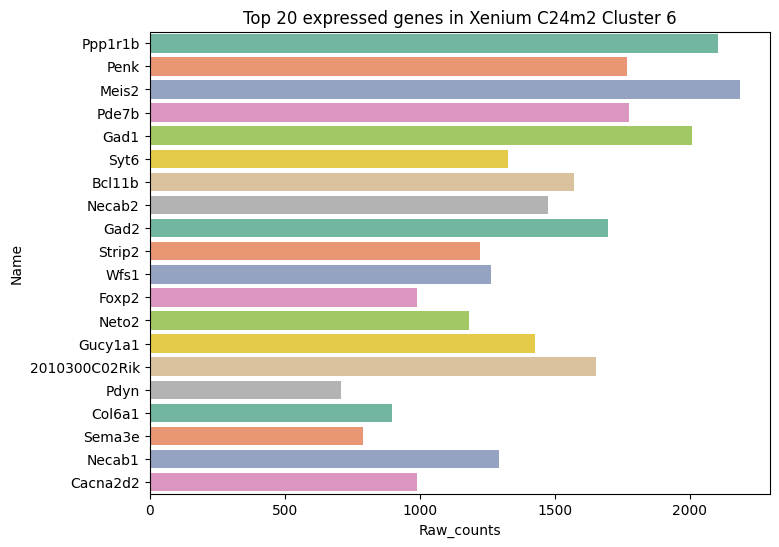

C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


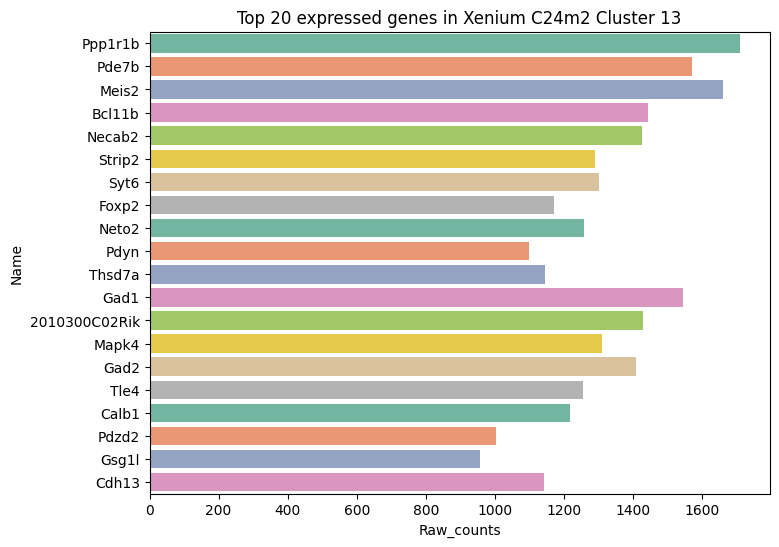

C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


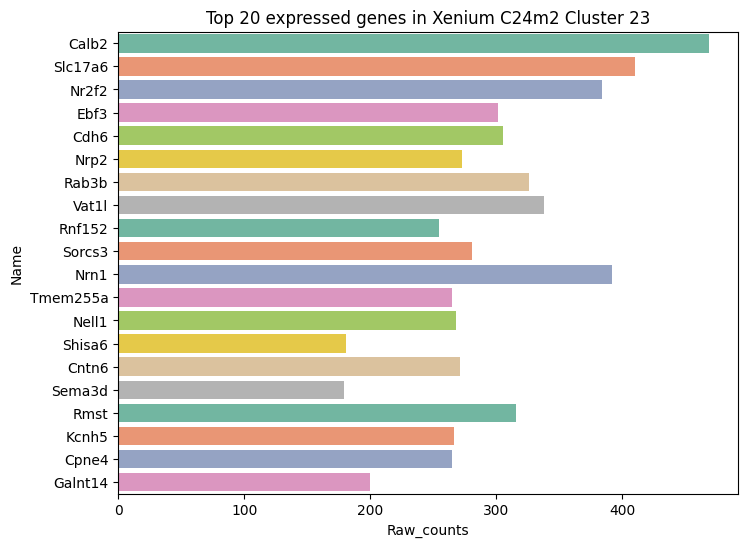

C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_39696\1447910767.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


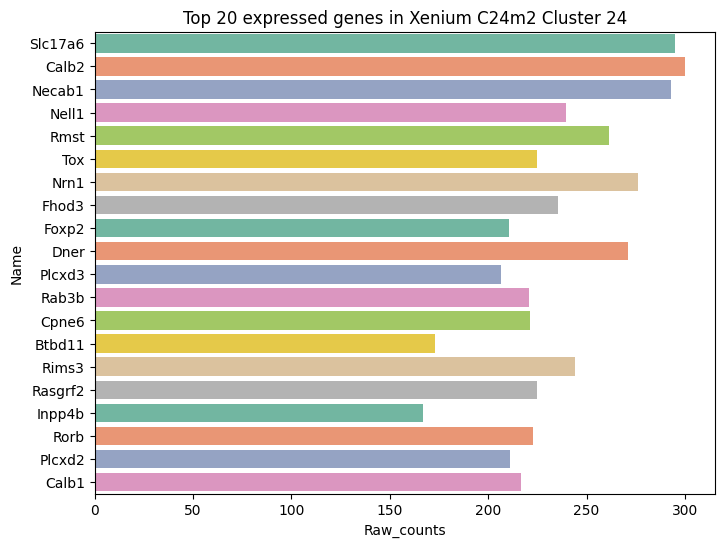

In [26]:
for cluster, i in zip(unlabeled_array, range(len(raw_gene_array))):
    x_label = raw_gene_array[i]
    y_label = c24m2.uns['rank_genes_groups']['names'][cluster][:20]
    graph_df = pd.DataFrame().assign(Name = y_label).assign(Raw_counts = x_label)
    #graph_df
    plt.style.use('default')
    plt.figure(figsize = (8, 6))
    sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
    plt.title(f'Top 20 expressed genes in Xenium C24m2 Cluster {cluster}')
    #plt.savefig(f'Xenium Cluster {cluster} top 20 gene expression bar chart')
    plt.show()

### Generate brain projection map

In [33]:
adata_c24m2 = Jenie(c24m2, 'c24m2', 'c24m2', pallete = 'c24m2')

In [34]:
unlabeled_clusters_array = np.array(['CLUSTER 5',
                                    'CLUSTER 6',
                                    'CLUSTER 13',
                                    'CLUSTER 17',
                                    'CLUSTER 21',
                                    'CLUSTER 23',
                                    'CLUSTER 24'])

In [35]:
c24m2_unlabeled = c24m2[c24m2.obs['cluster_names'].isin(unlabeled_clusters_array)]
c24m2_unlabeled

View of AnnData object with n_obs × n_vars = 10727 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [36]:
adata_c24m2_unlabeled = Jenie(c24m2_unlabeled, 'c24m2_unlabeled', 'c24m2_unlabeled', pallete = 'c24m2')

##### Cluster 5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


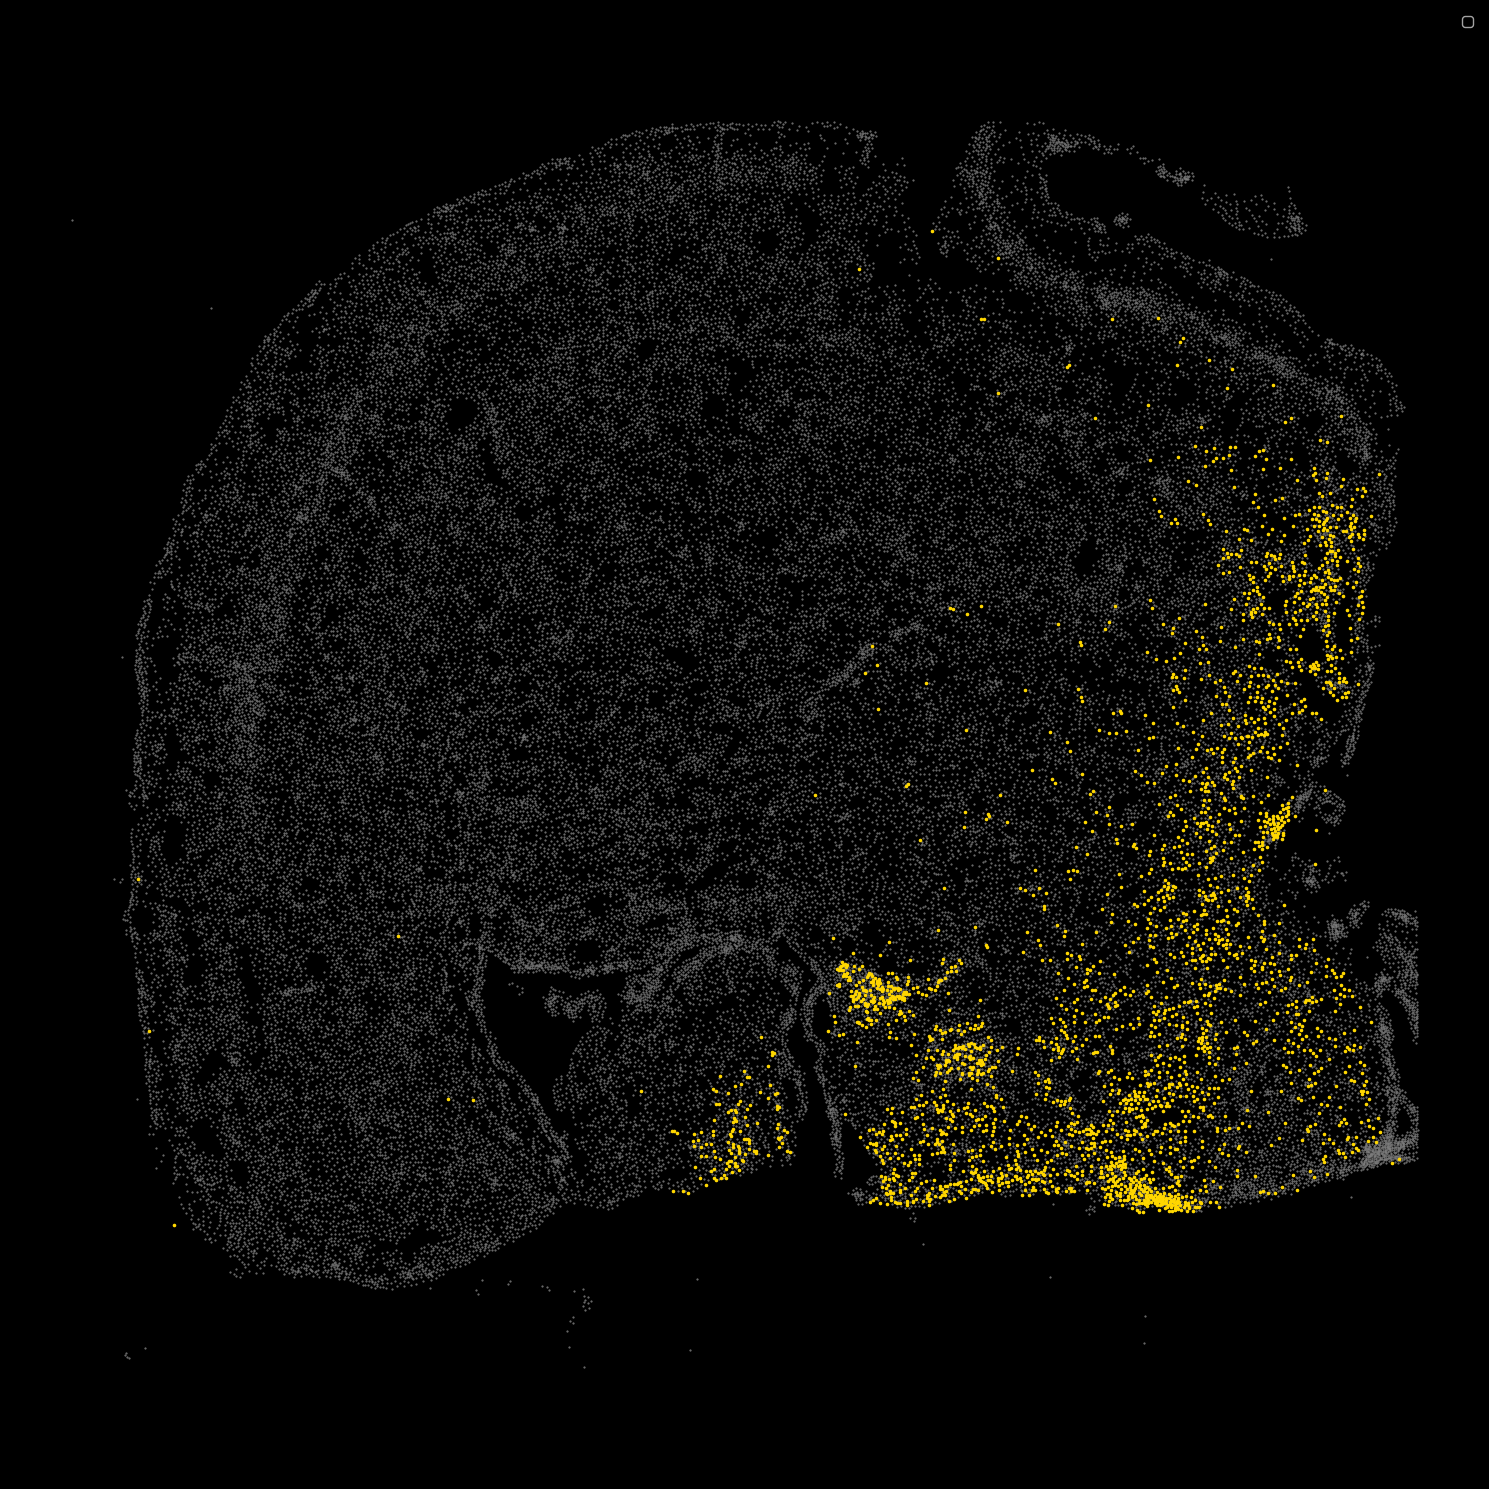

In [72]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 5'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

##### Cluster 6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


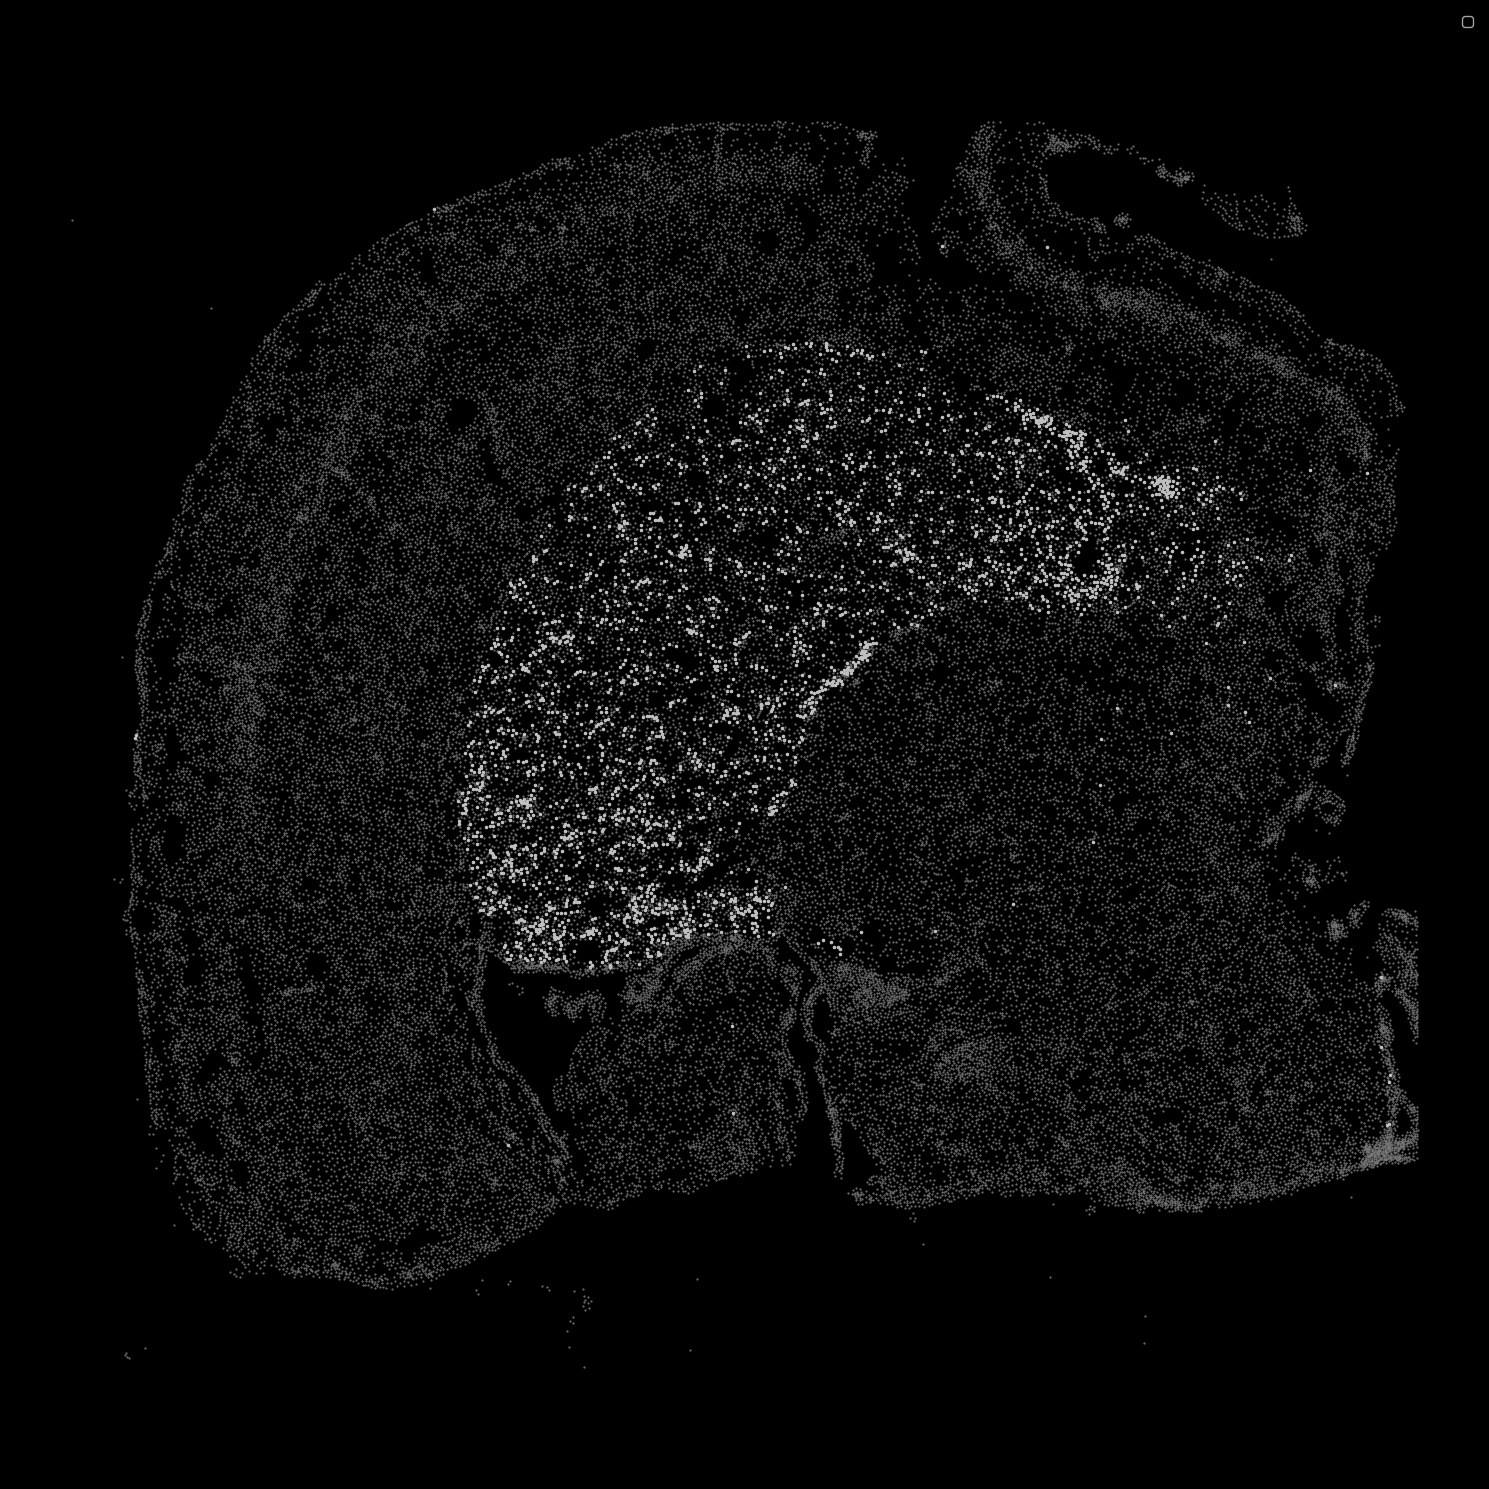

In [73]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 6'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

##### Cluster 13

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


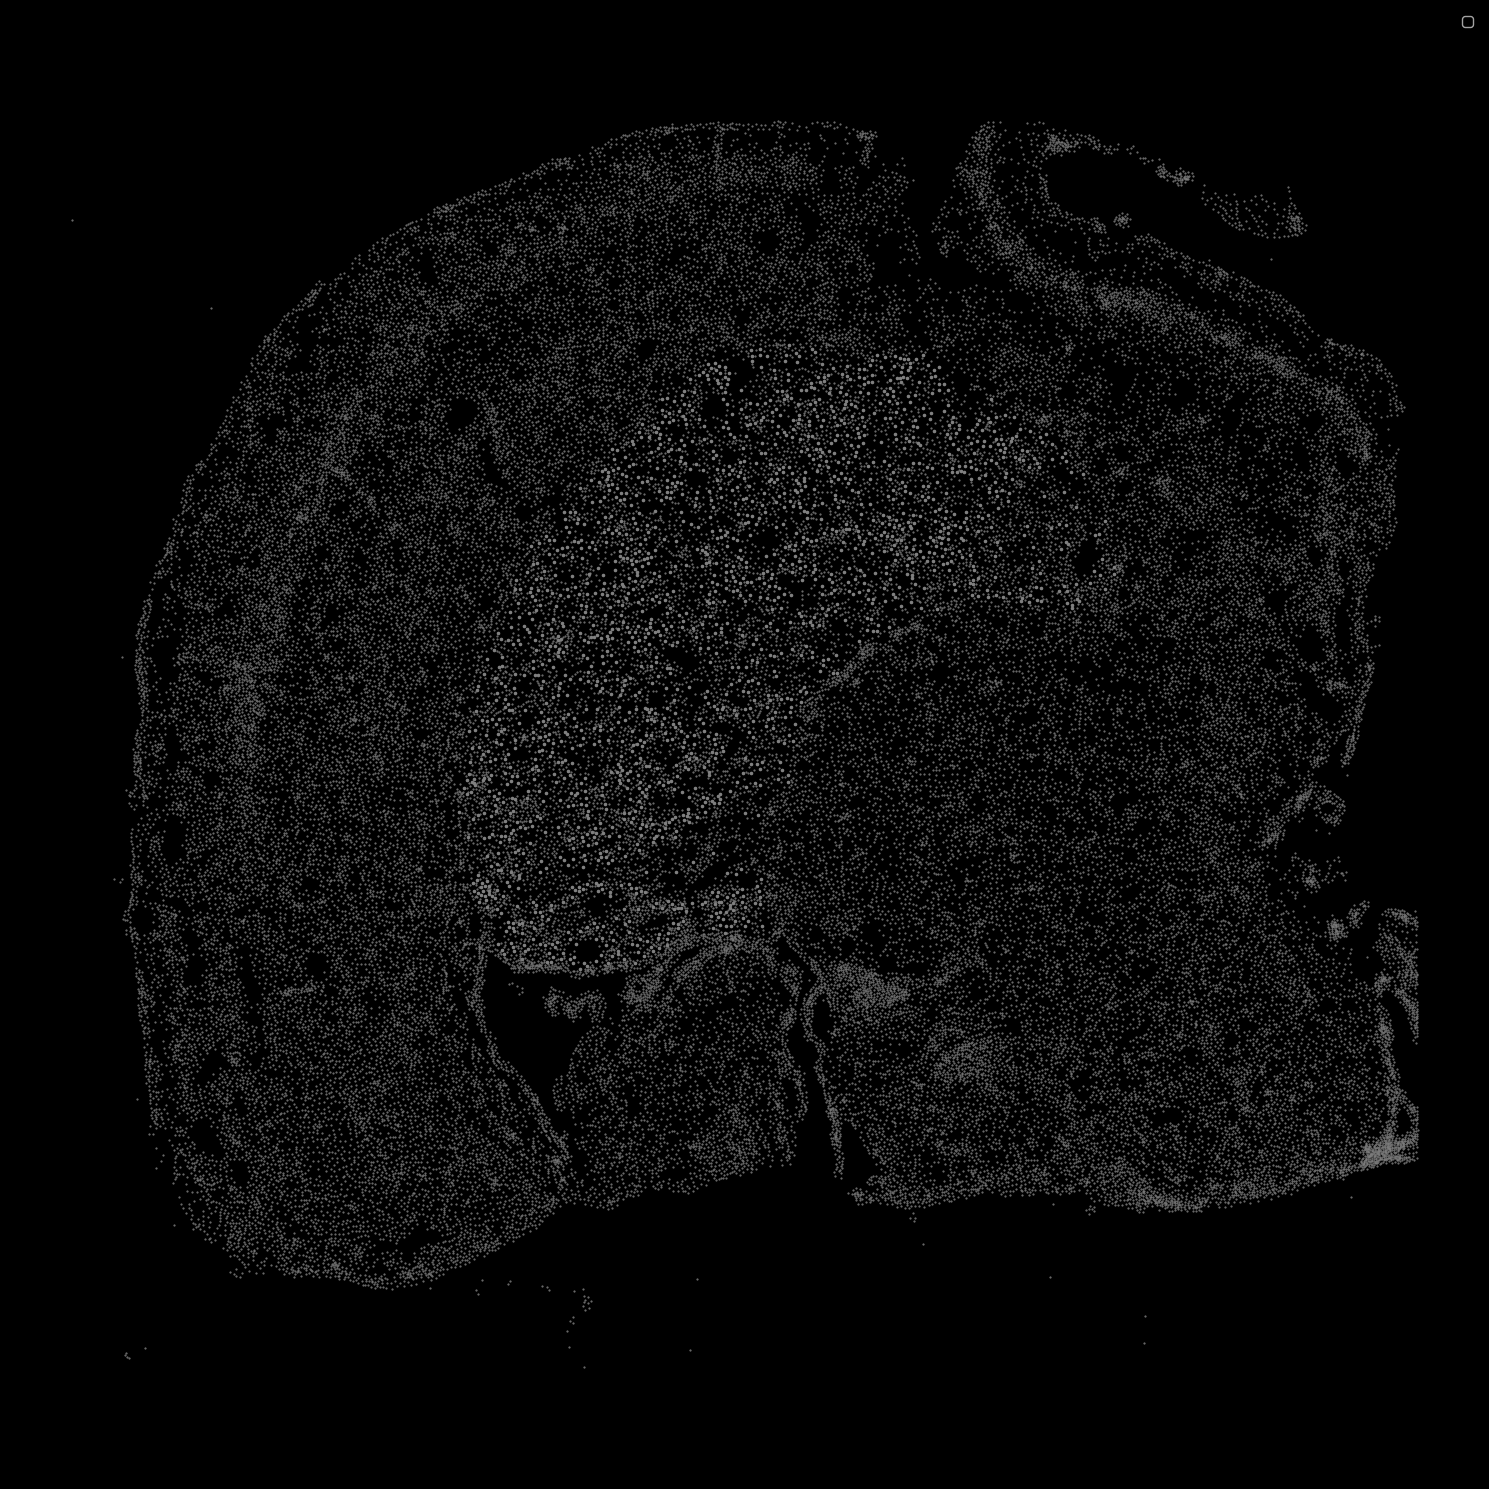

In [74]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 13'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

##### Cluster 17

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


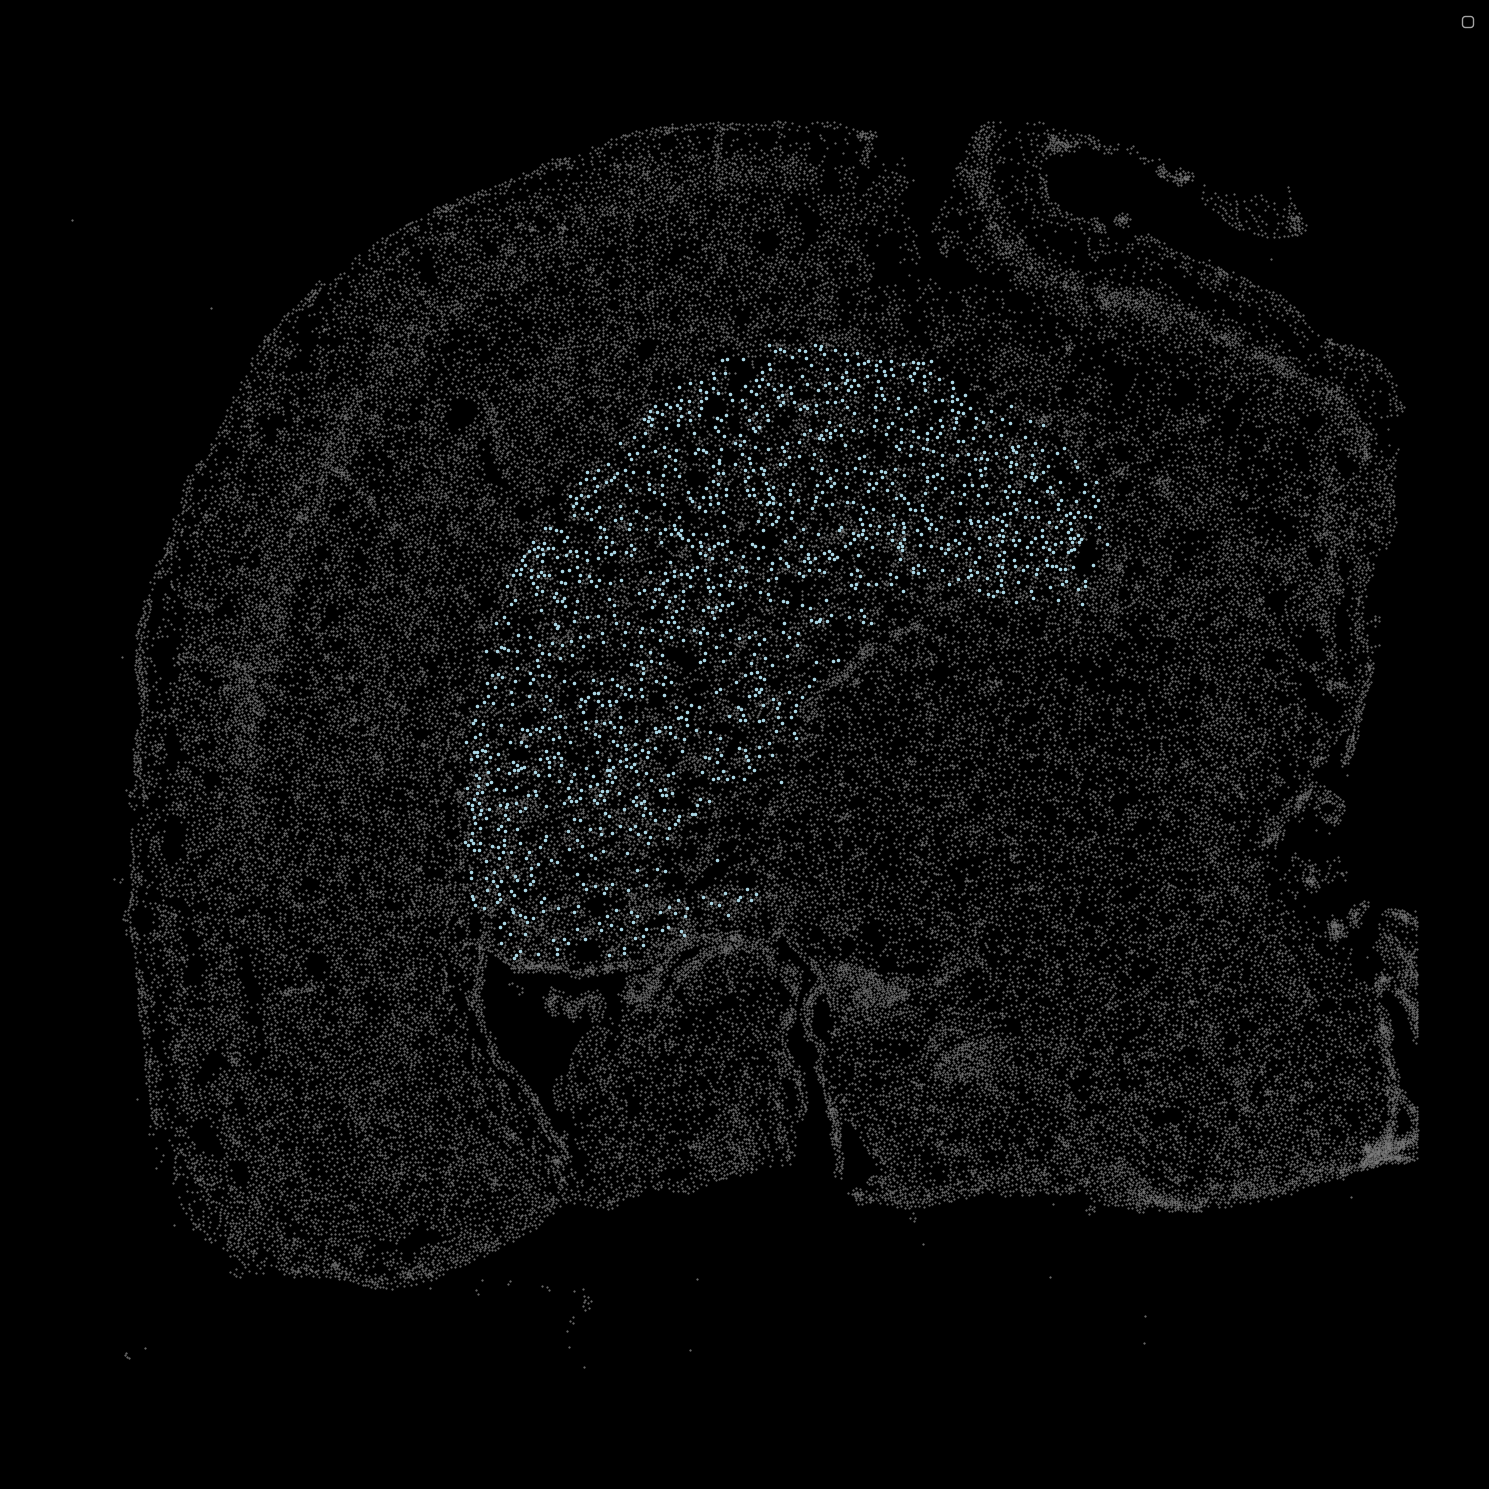

In [75]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 17'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

##### Cluster 21

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


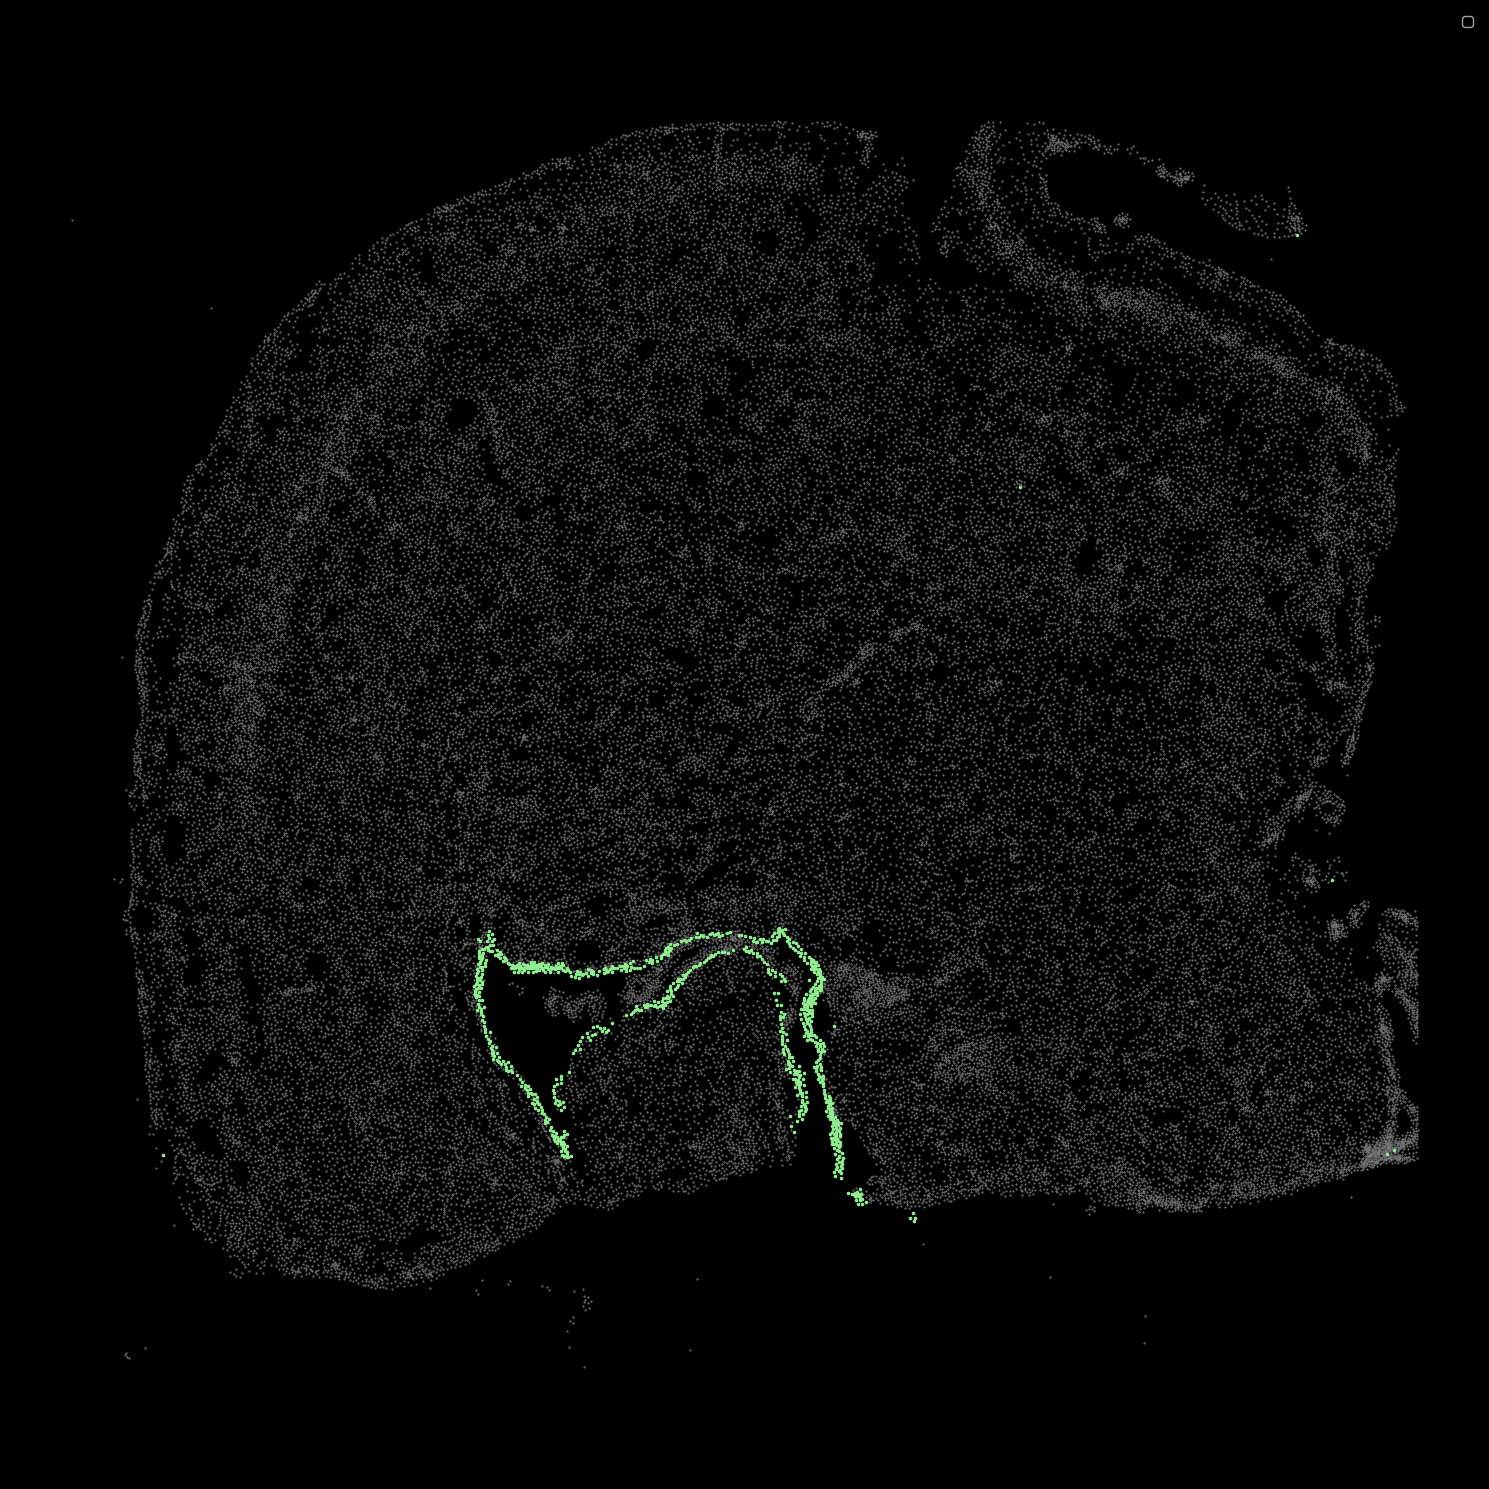

In [76]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 21'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

##### Cluster 23

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


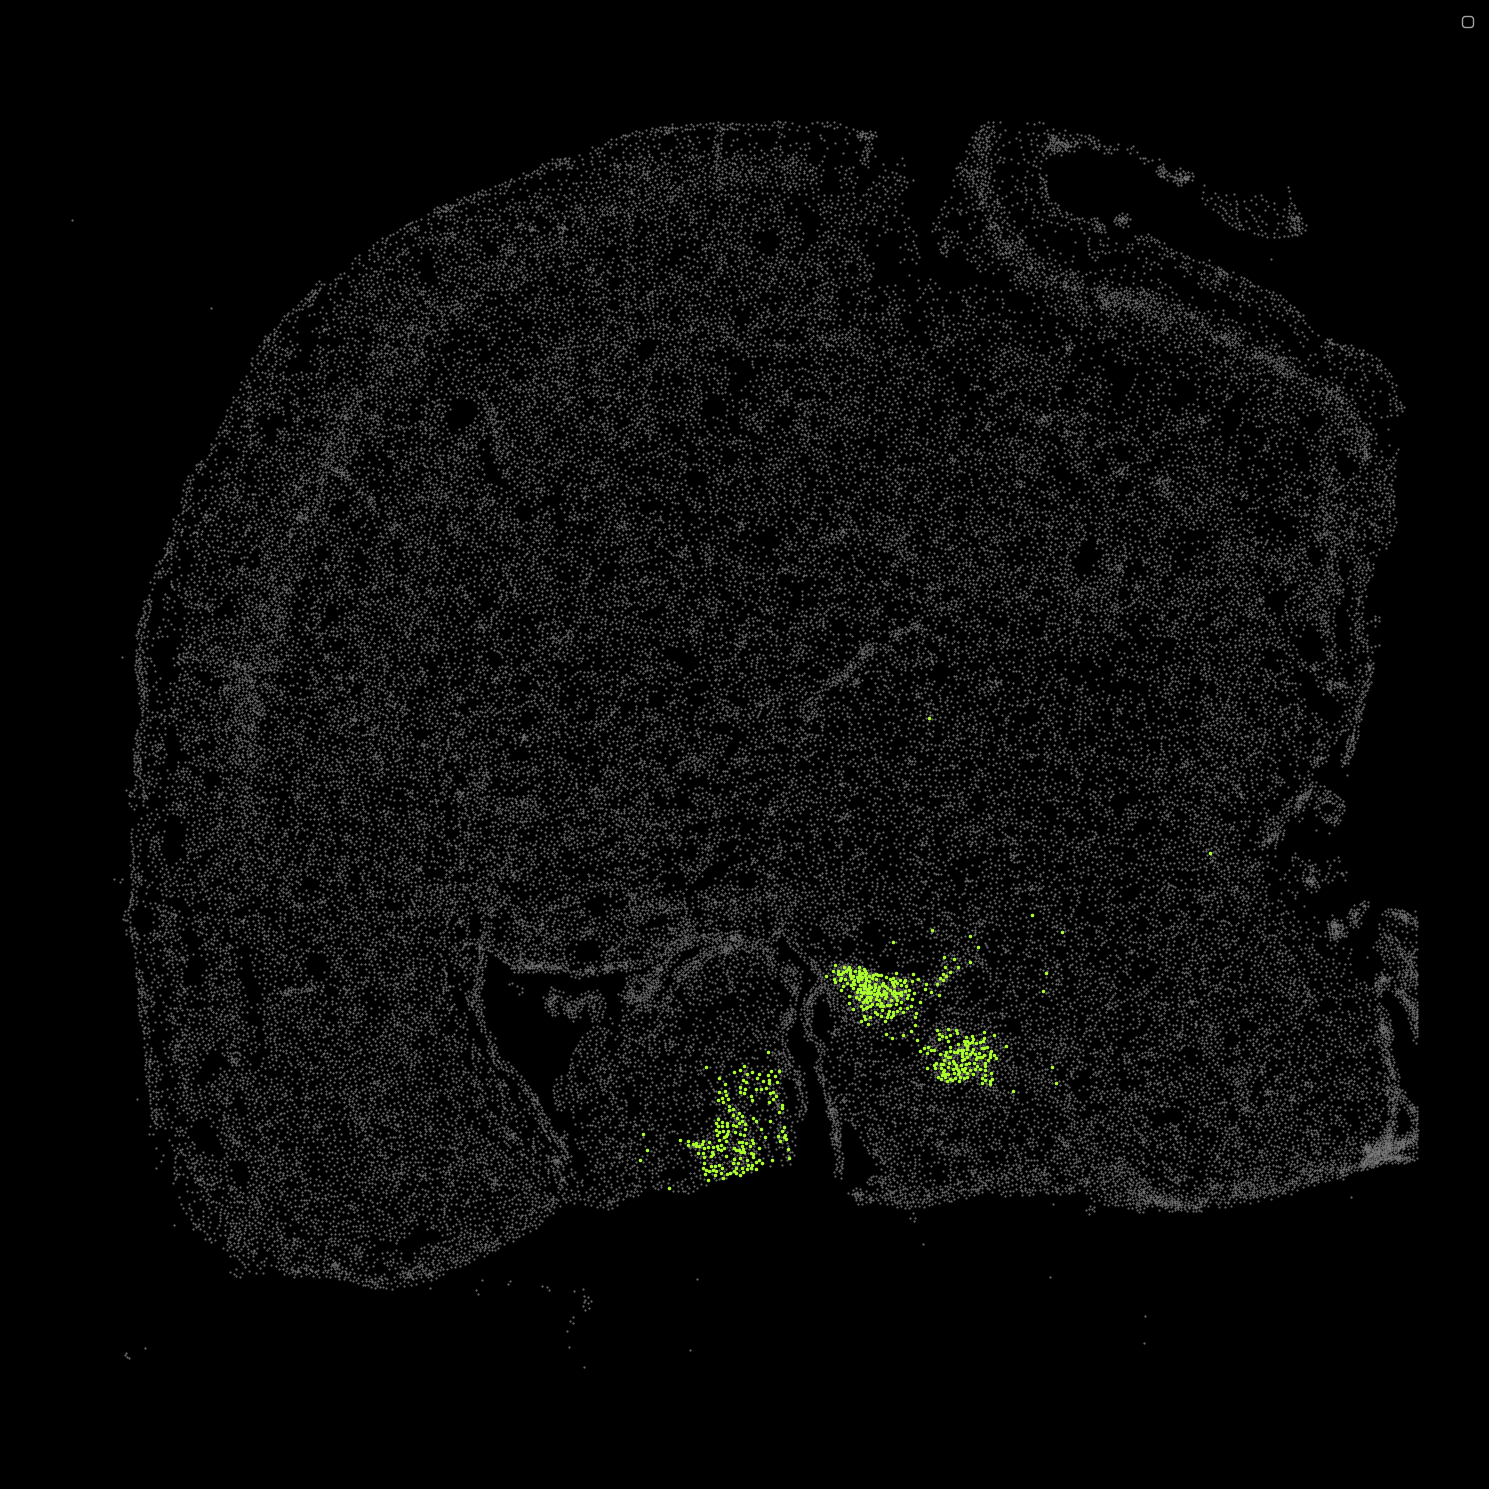

In [77]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 23'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

##### Cluster 24

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


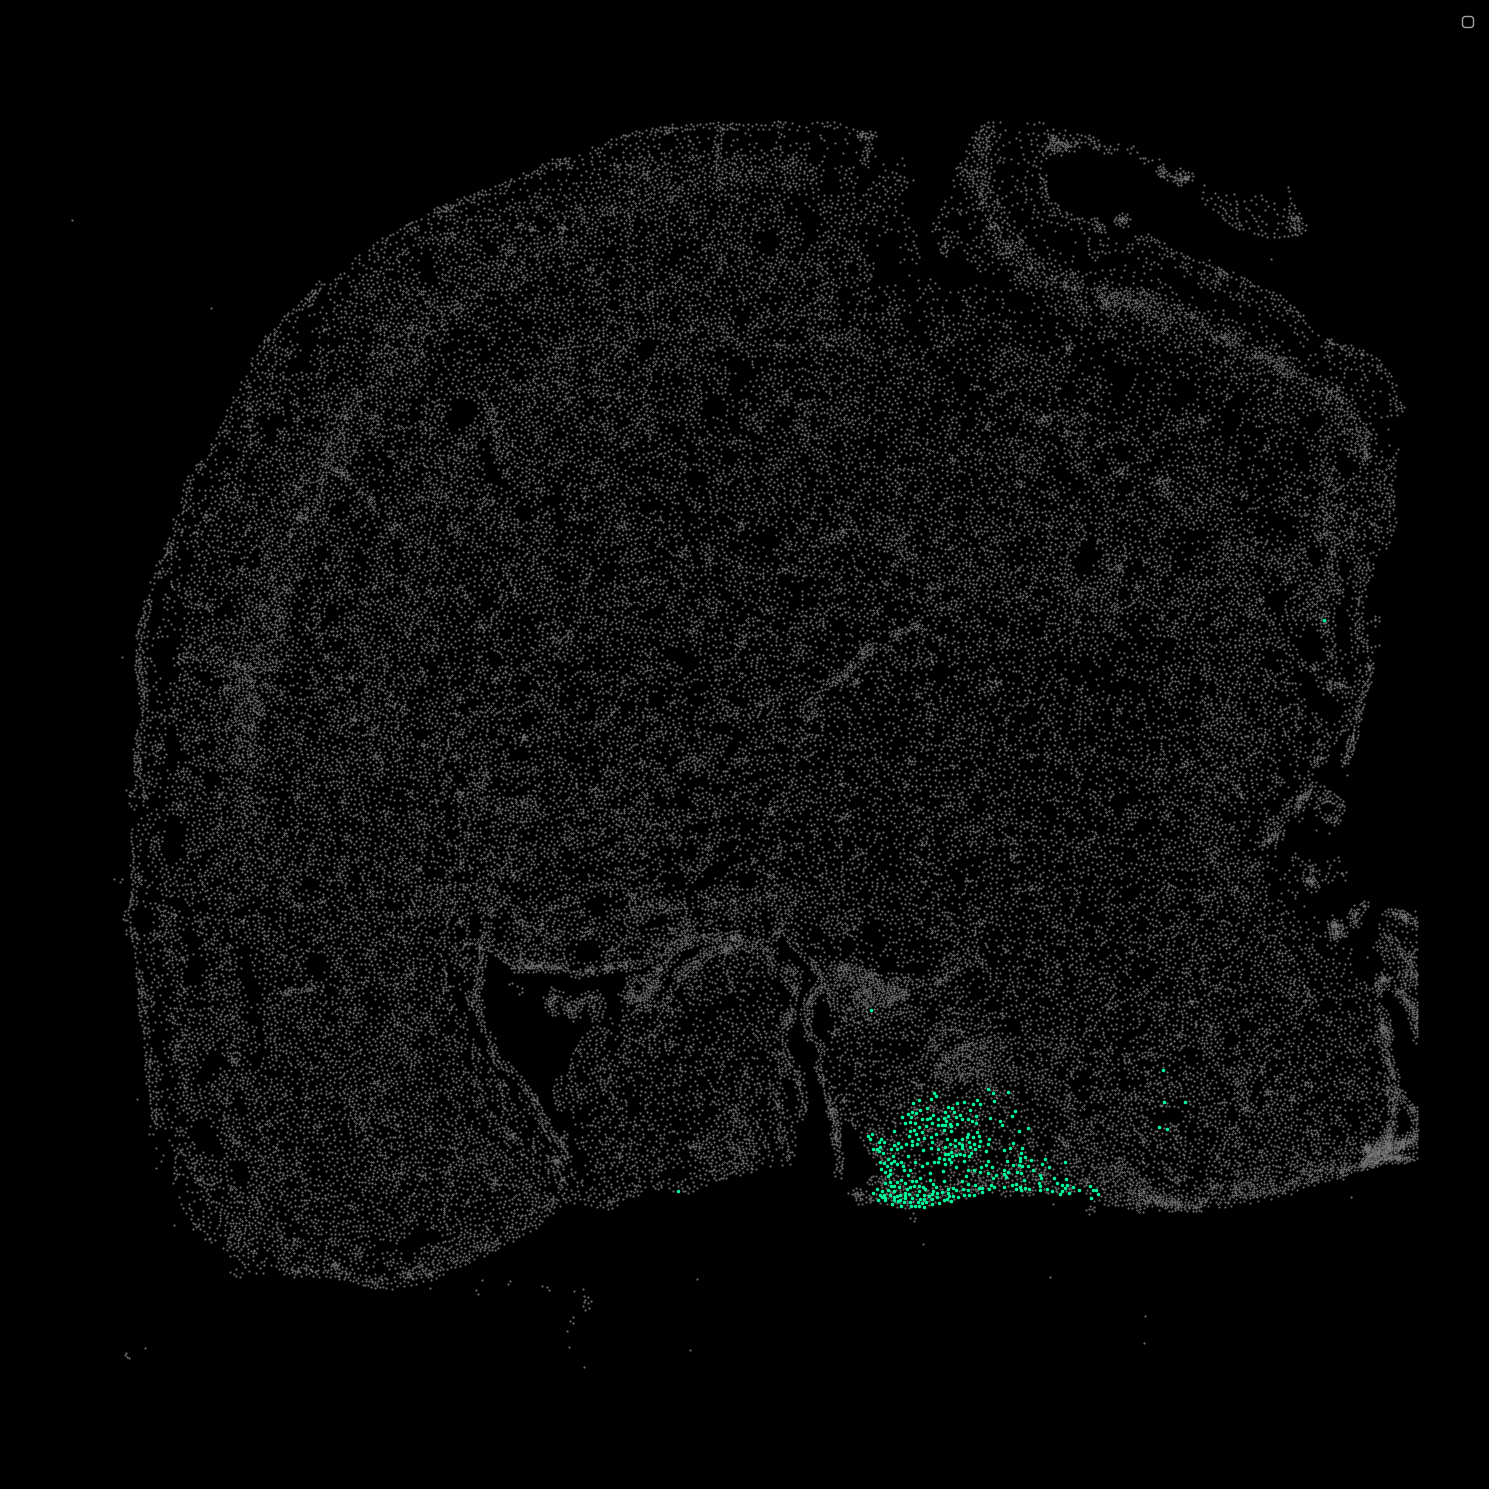

In [78]:
adata_c24m2_unlabeled.plot_cluster_scdata(group = 'cluster_names', clusters = ['CLUSTER 24'],  ref = c24m2, sbig = 10, ssm = 1, flipy = -1)

# Ingest all conditions into the c24m2

In [48]:
!pip install umap-learn --upgrade

   ---------------------------------------- 0.0/85.7 kB ? eta -:--:--
   ---------------------------------------- 85.7/85.7 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.5
    Uninstalling umap-learn-0.5.5:
      Successfully uninstalled umap-learn-0.5.5


In [65]:
sample_id_list = [c3m1, c3m2, c3m3, c24m1, c24m3, hd24m1, hd24m2, hd24m3, r61]
for sample_id in sample_id_list:
    sc.tl.ingest(sample_id, c24m2, obs = 'cluster_names')

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarnin

In [70]:
sample_id_string = ['C3m1', 'C3m2', 'C3m3', 'C24m1', 'C24m3', 'HD24m1', 'HD24m2', 'HD24m3', 'R61']

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


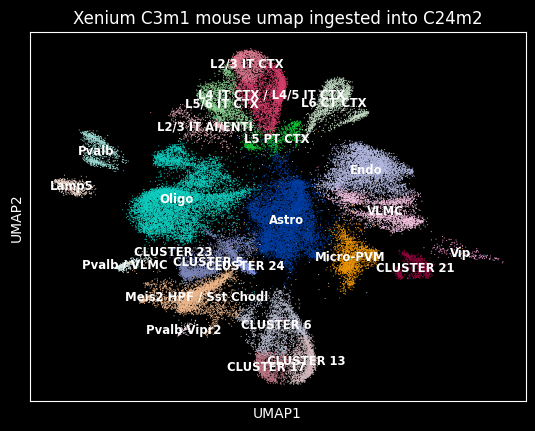

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


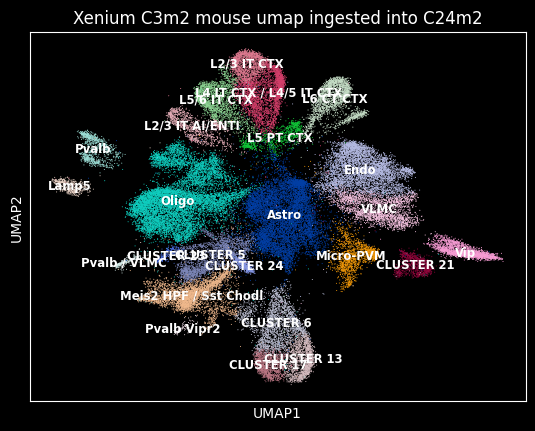

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


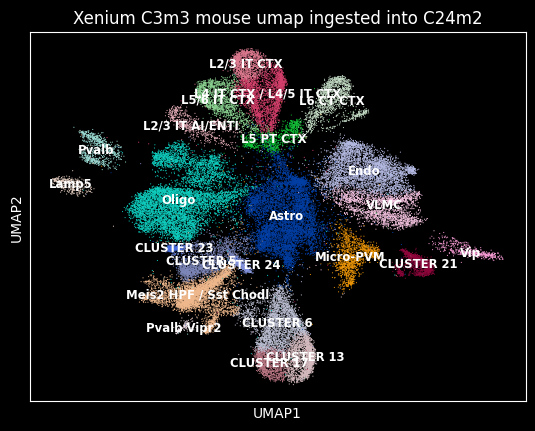

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


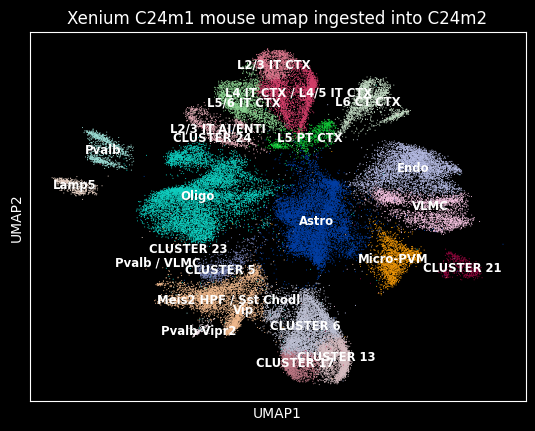

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


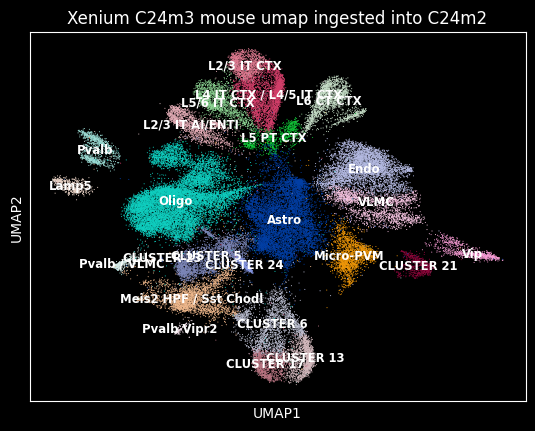

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


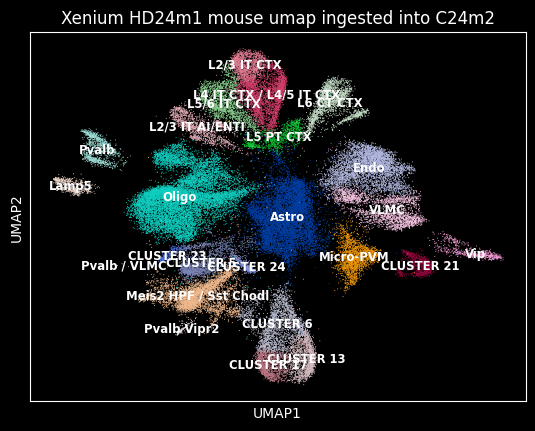

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


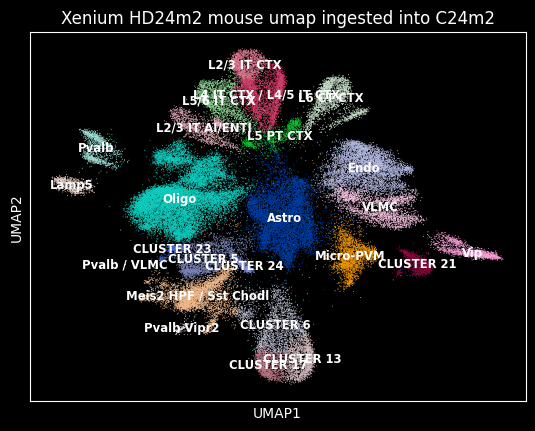

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


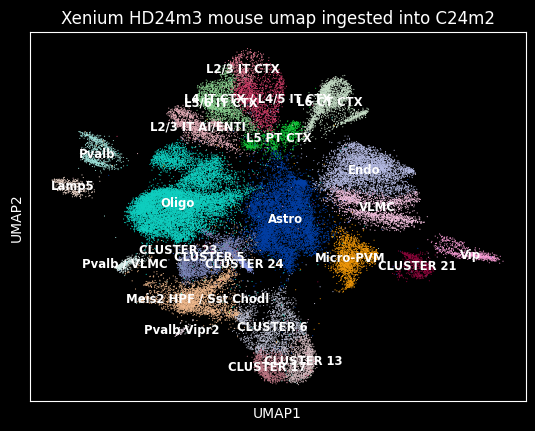

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


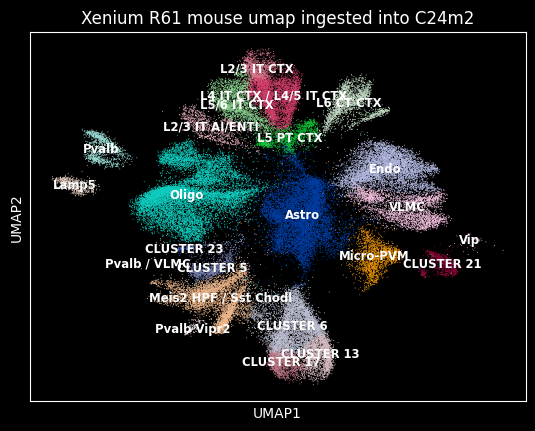

In [71]:
for sample_id, name in zip(sample_id_list, sample_id_string):
    sc.pl.umap(sample_id, 
               color = 'cluster_names', 
               title = f'Xenium {name} mouse umap ingested into C24m2', 
               legend_loc = 'on data', 
               legend_fontsize = 'small')